# Model Playground

Now add in the synthetic data here: /scratch/brandon.nelson/demos/pediatric_ich_cadt/study_plan.csv, and /scratch/brandon.nelson/demos/pediatric_ich_cadt/results

/scratch/brandon.nelson/demos/pediatric_ich_cadt/.demo/lib/python3.13/site-packages/monai/utils/module.py:399: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  pkg = __import__(module)  # top level module


,name,age,dataset,Epidural,Subdural,Intraparenchymal,Intraventricular,Subarachnoid,No_Hemorrhage,file
0,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
1,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
2,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
3,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
4,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
...,...,...,...,...,...,...,...,...,...,...
9639,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9640,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9641,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9642,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...


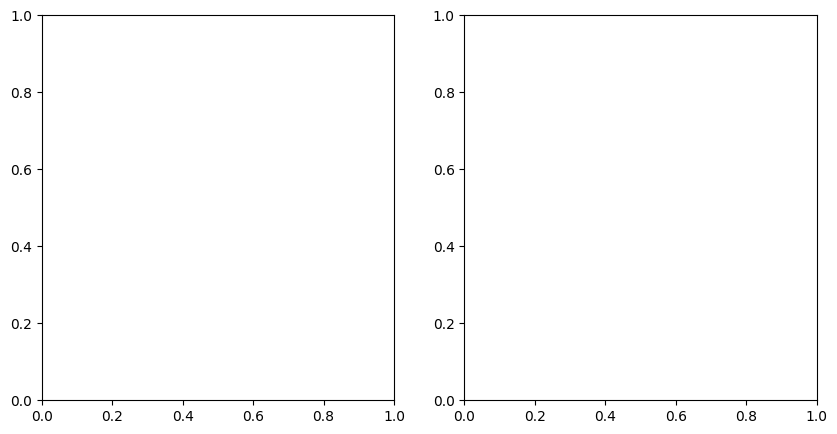

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
from gradio_demo import load_datasets

hssayeni_dir = '/projects01/didsr-aiml/brandon.nelson/pedsilicoICH/datasets/Hssayeni/'
synth_dir = Path('/scratch/brandon.nelson/demos/pediatric_ich_cadt/results')

patients = load_datasets(hssayeni_dir, synth_dir)
patients

In [2]:
import SimpleITK as sitk
vol = sitk.GetArrayFromImage(sitk.ReadImage(sorted(list(Path(patients[patients.name == 'synthetic 43']['file'].iloc[0]).glob('*.dcm')))))
vol.shape

(135, 512, 512)

# CAD module

In [3]:
from model_utils import InferenceManager

In [4]:
from model_utils import download_and_unzip
from dotenv import load_dotenv
import os
load_dotenv()

model_path = Path(os.environ['MODEL_PATH'])
if not model_path.exists():
    download_and_unzip('https://zenodo.org/records/15750437/files/model_files.zip', extract_to=model_path.parents[1]) 

In [5]:
models = {m.parts[-2]: m for m in sorted(list(model_path.rglob('*.pth')))}
models

{'CAD_1': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_1/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_2': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_2/resnext101_32x8d_wsl_checkpoint.pth'),
 'CAD_3': PosixPath('/scratch/brandon.nelson/demos/pediatric_ich_cadt/model_files/model_files/CAD_3/resnext101_32x8d_wsl_checkpoint.pth')}

In [6]:
patients

,name,age,dataset,Epidural,Subdural,Intraparenchymal,Intraventricular,Subarachnoid,No_Hemorrhage,file
0,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
1,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
2,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
3,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
4,49.0,35.00,Hssayeni,0.0,0.0,0.0,0.0,0.0,1.0,/projects01/didsr-aiml/brandon.nelson/pedsilic...
...,...,...,...,...,...,...,...,...,...,...
9639,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9640,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9641,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...
9642,synthetic 43,15.75,Synthetic,0.0,0.0,0.0,0.0,0.0,1.0,/scratch/brandon.nelson/demos/pediatric_ich_ca...


In [8]:
manager = InferenceManager(models['CAD_1'])
manager

In [9]:
import nibabel as nib

# labels for the model output

patient = patients.iloc[0]
images = nib.load(patient['file']).get_fdata().transpose(2, 1, 0)[:, ::-1]
images.shape

(39, 512, 512)

In [ ]:
manager.load_patient(images)

In [ ]:
manager.get_slice_prediction(1)

{'Epidural': 3.5887751e-07,
 'Intraparenchymal': 3.020801e-07,
 'Intraventricular': 1.8245759e-10,
 'Subarachnoid': 5.2964946e-08,
 'Subdural': 4.186222e-08,
 'Any': 6.7164365e-07}

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from model_utils import predict_image

import albumentations as A
import torch
import nibabel as nib

# labels for the model output

patient = patients.iloc[0]
images = nib.load(patient['file']).get_fdata().transpose(2, 1, 0)[:, ::-1]
name = patient['name']
age = patient['age']

def ict_pipeline(slice_num, width=5, model_name='CAD_1'):

    image = np.mean(images[slice_num:slice_num+width], axis=0) # create average
    out = predict_image(image, models[model_name], device='cuda')
    return image, out



def visualize_ict_pipeline(slice_num, width=5, thresh=0.3, model_name='CAD_1', show=True):
    diagnosis = pd.read_csv(Path(hssayeni_dir) / 'hemorrhage_diagnosis_raw_ct.csv')
    label = diagnosis.loc[(diagnosis.PatientNumber == name) & (diagnosis.SliceNumber == slice_num + 1)].to_numpy()[:, 2:-1]
    cols = diagnosis.columns[2:-1]
    subtype = cols[label.argmax()]

    image, out = ict_pipeline(slice_num, width, model_name)

    f, axs = plt.subplots(1, 2, figsize = (10, 4), dpi=150)
    axs[0].imshow(image, vmin=0, vmax=80, cmap='gray')
    axs[0].set_axis_off()
    axs[1].bar(out.keys(), out.values())
    axs[1].set_ylabel('model output')
    axs[1].set_ylim([0, 1])
    axs[1].hlines(thresh, 0, len(out), colors='red')
    out.pop('Any')
    max_label = [k for k, v in out.items() if v == max(out.values())][0]
    predicted_label = max_label if out[max_label] > thresh else 'No_Hemorrhage'
    color = 'green' if predicted_label == subtype else 'red'
    axs[0].set_title(f'age: {age}, \nmodel prediction: {predicted_label} | truth: {subtype}', color=color)
    fname = Path('results.png').absolute()
    if show:
        plt.show()
        return None
    else:
        plt.savefig(fname)
        return fname

start = 13
thresh = 0.3
visualize_ict_pipeline(start, width=1, thresh=0.3, model_name='CAD_1')

ValueError: attempt to get argmax of an empty sequence

In [ ]:
image, out = ict_pipeline(13, width, 'CAD_1')
out

{'EDH': np.float32(0.01235199),
 'IPH': np.float32(0.012318909),
 'IVH': np.float32(0.0045080506),
 'SAH': np.float32(0.029166538),
 'SDH': np.float32(0.34169638),
 'Any': np.float32(0.36785963)}

In [ ]:
from ipywidgets import interact, IntSlider, FloatSlider
interact(visualize_ict_pipeline,
         slice_num=IntSlider(len(images)//2, 0, len(images)),
         width=IntSlider(5, 1, 10),
         thresh=FloatSlider(0.3, min=0, max=1, step=0.1),
         model_name = list(models.keys()))

interactive(children=(IntSlider(value=18, description='slice_num', max=36), IntSlider(value=5, description='wi…

<function __main__.visualize_ict_pipeline(slice_num, width=5, thresh=0.3, model_name='CAD_1', show=True)>